In [1]:
!gdown 177JBVEDNSQMqHHh-oBtFdNyRJSmxTIhz
!pip install seaborn phik

Downloading...
From: https://drive.google.com/uc?id=177JBVEDNSQMqHHh-oBtFdNyRJSmxTIhz
To: /content/train_3.2.csv
100% 10.9M/10.9M [00:00<00:00, 98.2MB/s]


Загрузите данные. Проведите EDA по вашему датасету, опишите основные идеи для последующей генерации новых признаков.

Проведите разбиение на тренировочные и валидационные данные. Проведите необходимую предобработку данных для последующего обучения нейронной сети.

Реализуйте функцию, в которой вы будете определять архитектуру модели. Функция должна возвращать скомпилированную модель.

Обучите модель нейронной сети (без использования методов регуляризации) на исходной тренировочной выборке (без добавления новых признаков). В процессе обучения нужно отслеживать метрику ROC_AUC на каждой эпохе, на валидационных данных.

Сгенерируйте новые признаки исходя из вашего EDA или наоборот — удалите ненужные признаки, которые препятствуют лучшему качеству модели при обучении. 

Переобучите модель на данных, которые представляют из себя новый датафрейм, и оцените, как изменилось качество модели (то есть вы либо добавили новые признаки, либо удалили старые, либо всё вместе). Исходя из этого примите решение, какие новые признаки хорошо повлияли на качество, а какие нет.

Собрав финальный датасет, который состоит из отфильтрованных (или добавленных) новых признаков, добавьте в вашу модель методы регуляризации — BatchNorm, Dropout, EarlyStopping, а также реализуйте автоматическое сохранение наилучших весов по метрике ROC_AUC на лучшей эпохе.

Напишите вывод по всему проекту, он должен содержать в себе:

Какие методы регуляризации улучшили качество, а какие плохо повлияли

Какие признаки повлияли на качество обучения (в лучшую сторону)

Наилучшую метрику ROC_AUC на валидации

In [2]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.preprocessing import FunctionTransformer
from itertools import combinations_with_replacement
from keras.layers import Dense, BatchNormalization, Dropout
import phik
from phik import report
import seaborn as sns
from sklearn.utils import class_weight
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [3]:
df = pd.read_csv('train_3.2.csv')

In [4]:
df.describe()

,id,loc,v(g),ev(g),iv(g),n,v,l,d,i,...,t,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount
count,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,...,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000
mean,50881.000000,37.347160,5.492684,2.845022,3.498826,96.655995,538.280956,0.111634,13.681881,27.573007,...,1141.357982,22.802453,1.773945,3.979865,0.196604,11.896131,15.596671,57.628116,39.249698,9.839549
std,29376.592059,54.600401,7.900855,4.631262,5.534541,171.147191,1270.791601,0.100096,14.121306,22.856742,...,9862.795472,38.541010,5.902412,6.382358,0.998906,6.749549,18.064261,104.537660,71.692309,14.412769
min,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,25440.500000,13.000000,2.000000,1.000000,1.000000,25.000000,97.670000,0.050000,5.600000,15.560000,...,31.380000,7.000000,0.000000,1.000000,0.000000,8.000000,7.000000,15.000000,10.000000,3.000000
50%,50881.000000,22.000000,3.000000,1.000000,2.000000,51.000000,232.790000,0.090000,9.820000,23.360000,...,125.400000,14.000000,0.000000,2.000000,0.000000,11.000000,12.000000,30.000000,20.000000,5.000000
75%,76321.500000,42.000000,6.000000,3.000000,4.000000,111.000000,560.250000,0.150000,18.000000,34.340000,...,565.920000,26.000000,1.000000,5.000000,0.000000,16.000000,20.000000,66.000000,45.000000,11.000000
max,101762.000000,3442.000000,404.000000,165.000000,402.000000,8441.000000,80843.080000,1.000000,418.200000,569.780000,...,935923.390000,2824.000000,344.000000,219.000000,43.000000,410.000000,1026.000000,5420.000000,3021.000000,503.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101763 entries, 0 to 101762
Data columns (total 23 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 101763 non-null  int64  
 1   loc                101763 non-null  float64
 2   v(g)               101763 non-null  float64
 3   ev(g)              101763 non-null  float64
 4   iv(g)              101763 non-null  float64
 5   n                  101763 non-null  float64
 6   v                  101763 non-null  float64
 7   l                  101763 non-null  float64
 8   d                  101763 non-null  float64
 9   i                  101763 non-null  float64
 10  e                  101763 non-null  float64
 11  b                  101763 non-null  float64
 12  t                  101763 non-null  float64
 13  lOCode             101763 non-null  int64  
 14  lOComment          101763 non-null  int64  
 15  lOBlank            101763 non-null  int64  
 16  lo

In [6]:
X = df.drop('defects',axis=1)
y = df['defects'].astype(int)

interval columns not set, guessing: ['id', 'loc', 'v(g)', 'ev(g)', 'iv(g)', 'n', 'v', 'l', 'd', 'i', 'e', 'b', 't', 'lOCode', 'lOComment', 'lOBlank', 'locCodeAndComment', 'uniq_Op', 'uniq_Opnd', 'total_Op', 'total_Opnd', 'branchCount']


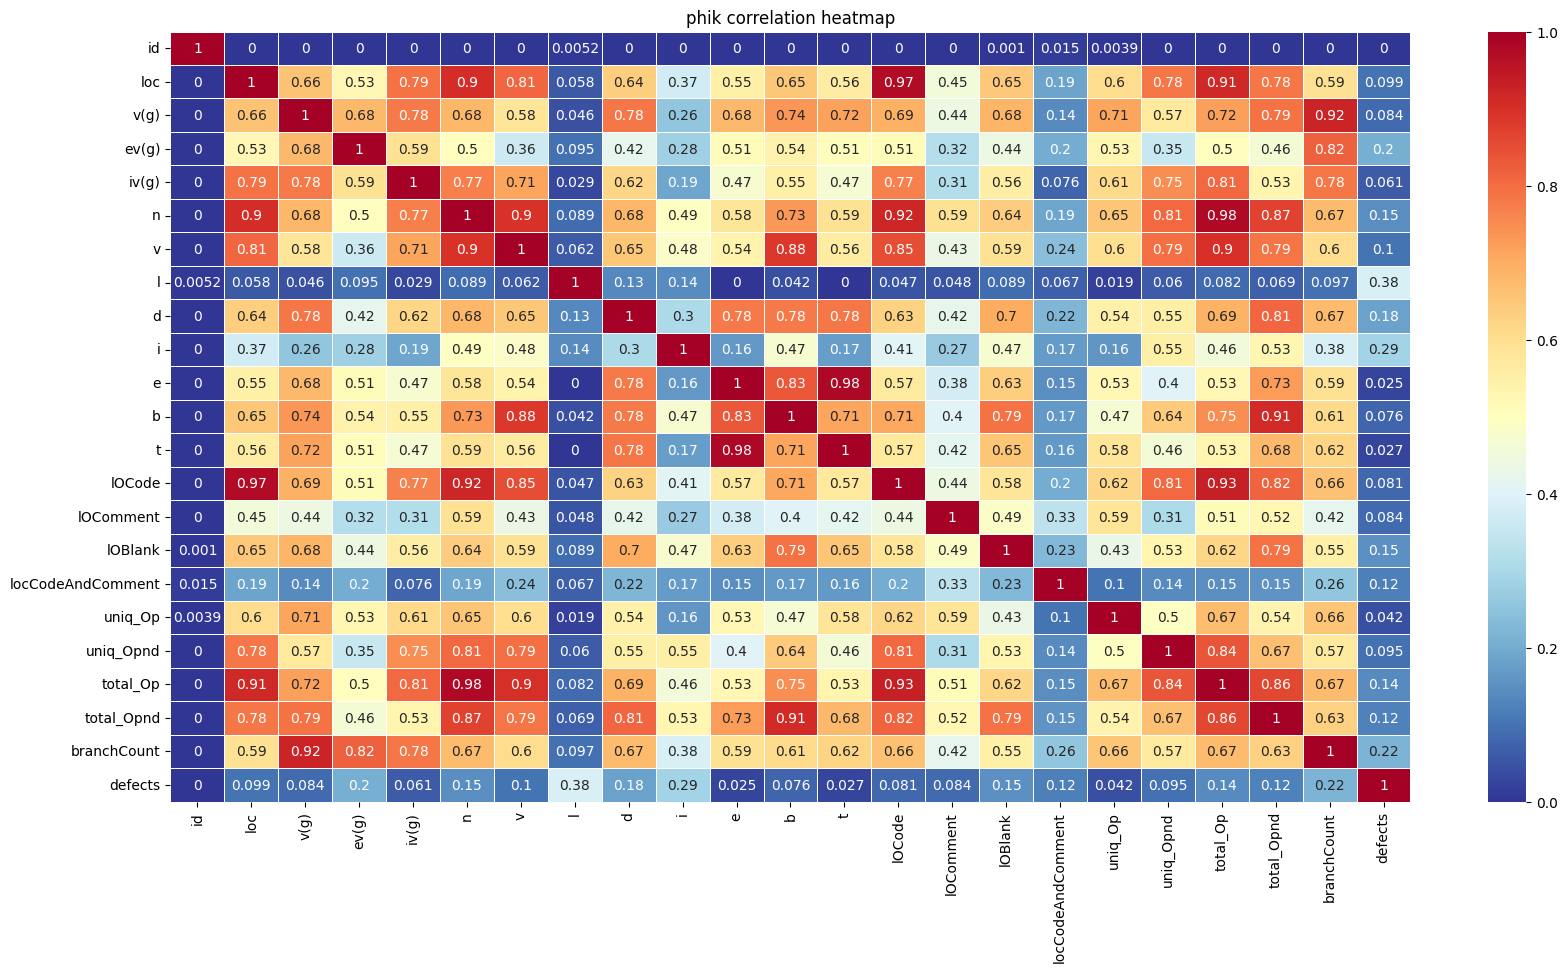

In [7]:
correlation_matrix = df.phik_matrix()

plt.figure(figsize=(20,10))
sns.heatmap(correlation_matrix,
        xticklabels=correlation_matrix.columns,
        yticklabels=correlation_matrix.columns,
        cmap='RdYlBu_r',
        annot=True,
        linewidth=0.5)

plt.title('phik correlation heatmap')
plt.show()

Id с нулевой корреляцией относительно всех фичей, можно исключить

In [8]:
X = X.drop('id',axis=1)

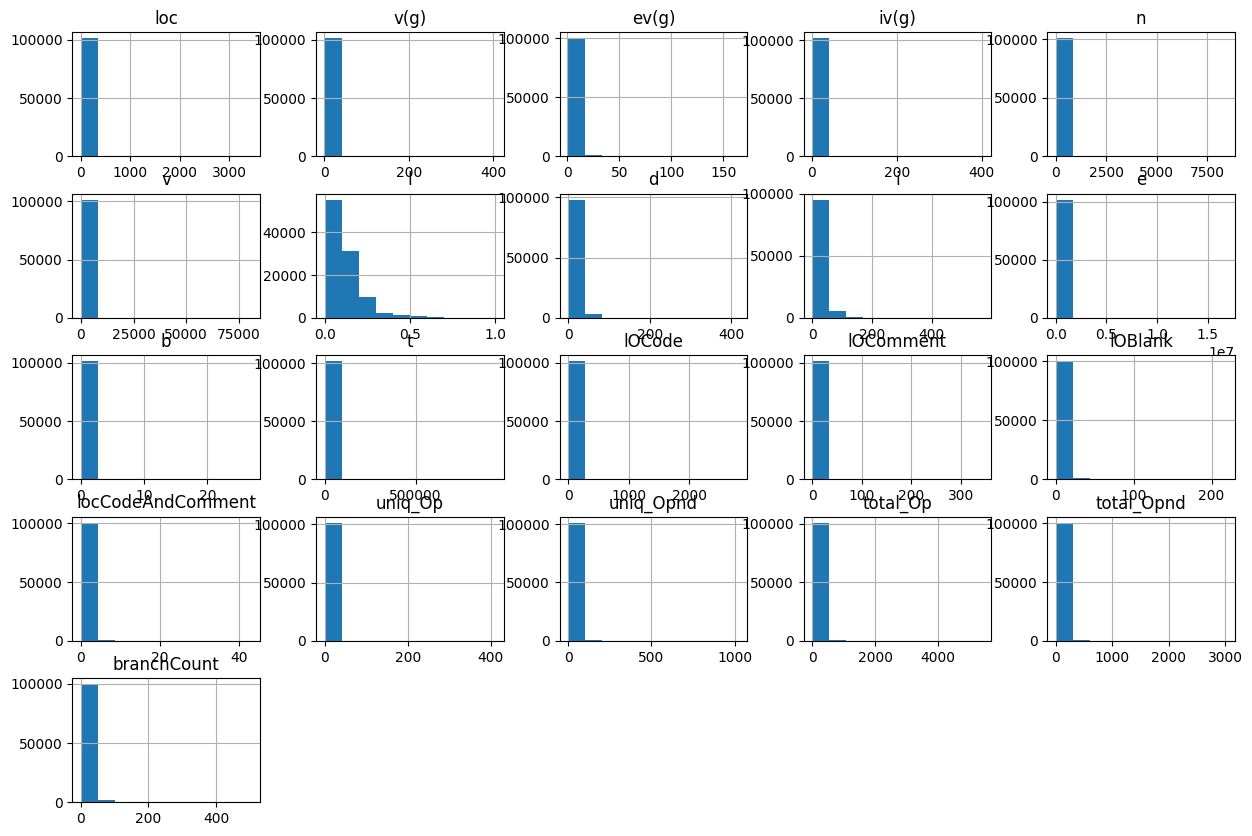

In [9]:
X.hist(figsize=(15, 10));

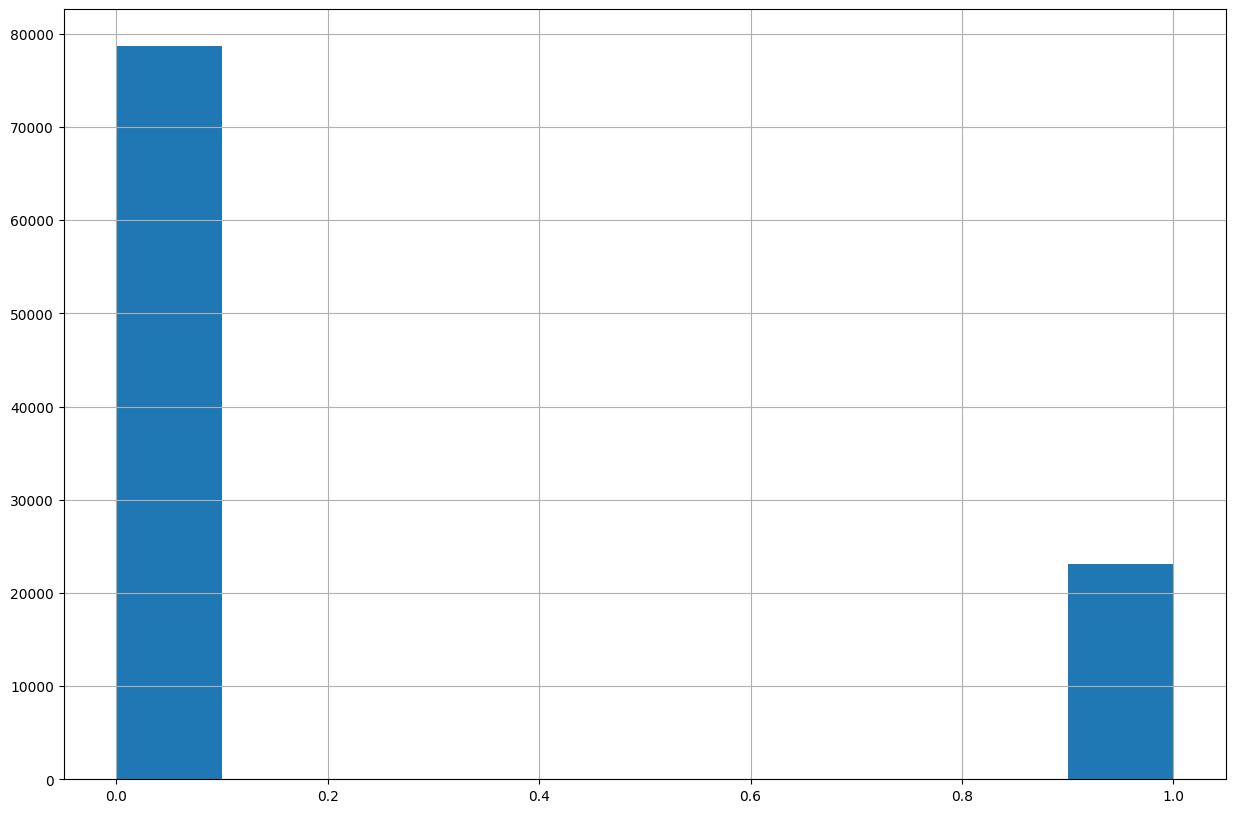

In [10]:
y.hist(figsize=(15, 10));

In [49]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

In [12]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [13]:
def create_model():
    model = Sequential()
    model.add(Dense(128, activation='relu', input_dim=X_train.shape[1]))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['AUC']
                  )

    return model

In [14]:
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights

array([0.64653187, 2.20611349])

In [15]:
model = create_model()

history = model.fit(X_train, y_train,
           validation_data=(X_val, y_val),
           epochs=50,
           batch_size=256,
           class_weight={0:class_weights[0], 1:class_weights[1]})

Epoch 1/50
319/319 [==============================] - 5s 7ms/step - loss: 0.5634 - auc: 0.7820 - val_loss: 0.5341 - val_auc: 0.7897
Epoch 2/50
319/319 [==============================] - 2s 7ms/step - loss: 0.5557 - auc: 0.7878 - val_loss: 0.5792 - val_auc: 0.7908
Epoch 3/50
319/319 [==============================] - 3s 8ms/step - loss: 0.5542 - auc: 0.7890 - val_loss: 0.5563 - val_auc: 0.7905
Epoch 4/50
319/319 [==============================] - 2s 7ms/step - loss: 0.5533 - auc: 0.7898 - val_loss: 0.5437 - val_auc: 0.7905
Epoch 5/50
319/319 [==============================] - 2s 5ms/step - loss: 0.5529 - auc: 0.7902 - val_loss: 0.5574 - val_auc: 0.7903
Epoch 6/50
319/319 [==============================] - 2s 5ms/step - loss: 0.5527 - auc: 0.7902 - val_loss: 0.5341 - val_auc: 0.7902
Epoch 7/50
319/319 [==============================] - 2s 5ms/step - loss: 0.5523 - auc: 0.7904 - val_loss: 0.5582 - val_auc: 0.7903
Epoch 8/50
319/319 [==============================] - 2s 5ms/step - loss: 0.

In [16]:
# Получение значений лосса и валидационного лосса из истории
def check_metrics(history, figure_name):

    train = history.history[f'{figure_name}']
    val = history.history[f'val_{figure_name}']

    # Построение графика лосса и валидационного лосса
    epochs = range(1, len(train) + 1)
    plt.plot(epochs, train, 'b', label=f'Training {figure_name}', color='orange')
    plt.plot(epochs, val, 'b', label=f'Validation {figure_name}')
    plt.title(f'Training and Validation {figure_name}')
    plt.xlabel('Epochs')
    plt.ylabel(f'{figure_name}')
    plt.legend()
    plt.show()

<ipython-input-16-1b78b09c4d6e>:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, train, 'b', label=f'Training {figure_name}', color='orange')


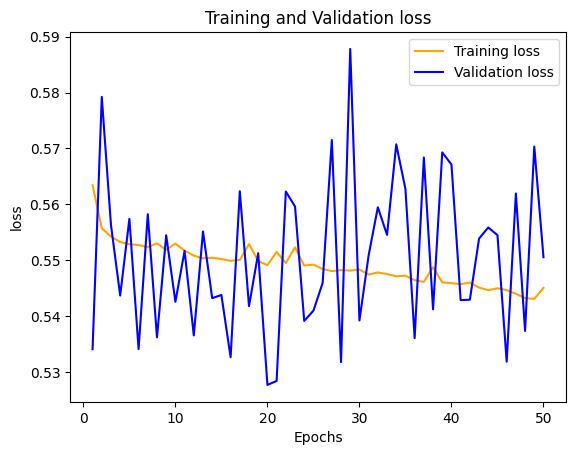

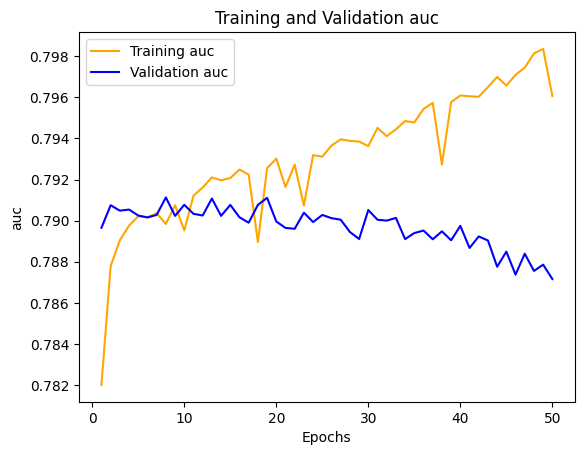

In [17]:
check_metrics(history, 'loss')
check_metrics(history, 'auc')

Напишем функции для трансформации исходных фич

In [50]:
def apply_log1p_transform(X_data):
    log1p = FunctionTransformer(np.log1p)
    transformed_X = log1p.transform(X_data)
    transformed_df = pd.DataFrame(transformed_X, columns=[f'log1p_{col}' for col in X_data.columns])
    return transformed_df

def apply_sqrt_transform(X_data):
    sqrt = FunctionTransformer(np.sqrt)
    transformed_X = sqrt.transform(X_data)
    transformed_df = pd.DataFrame(transformed_X, columns=[f'sqrt_{col}' for col in X_data.columns])
    return transformed_df

def apply_abs_transform(X_data):
    abs_transformer = FunctionTransformer(np.abs)
    transformed_X = abs_transformer.transform(X_data)
    transformed_df = pd.DataFrame(transformed_X, columns=[f'abs_{col}' for col in X_data.columns])
    return transformed_df

def polynomial_features(X, degree=2, include_bias=True):
    """
    Преобразует входные функции в полиномиальные функции заданной степени.

    Аргументы:
    X (pandas.DataFrame или numpy.ndarray): Входные функции с размерностью (n_samples, n_features).
    degree (int): Степень полиномиальных функций.
    include_bias (bool): Определяет, следует ли включать столбец сдвига.

    Возвращает:
    pandas.DataFrame: Матрица полиномиальных функций с размерностью (n_samples, n_output_features).
    """
    if isinstance(X, pd.DataFrame):
        X_array = X.to_numpy()
        feature_names = X.columns.tolist()
    else:
        X_array = np.array(X)
        feature_names = None

    n_samples, n_features = X_array.shape
    combinations = list(combinations_with_replacement(range(n_features), degree))
    n_output_features = len(combinations)
    if include_bias:
        n_output_features += 1
    X_poly = np.empty((n_samples, n_output_features))

    if include_bias:
        X_poly[:, 0] = 1

    start_idx = 1 if include_bias else 0
    for i, combo in enumerate(combinations):
        X_poly[:, start_idx + i] = np.prod(X_array[:, combo], axis=1)

    if feature_names is not None:
        feature_combinations = [""] if include_bias else []
        for combo in combinations:
            combination_names = [feature_names[idx] for idx in combo]
            feature_combinations.append("*".join(combination_names))

        return pd.DataFrame(data=X_poly, columns=feature_combinations)

    return X_poly

Создадим новые фичи

In [51]:
X_log1p = apply_log1p_transform(X)
X_sqrt = apply_sqrt_transform(X)
X_abs = apply_abs_transform(X)
X_poly = polynomial_features(X, degree=2, include_bias=False)
X_all = pd.concat([X_log1p, X_sqrt, X_abs, X, y, X_poly], axis=1)

Расчитаем корреляции фич, отсортируем их по значению корреляции

In [20]:
all_features = list(X_all.drop('defects',axis=1).columns)
cor = []
for f in all_features:
  try:
    correlation = pd.concat([X_all[f],y], axis=1).phik_matrix()[f][1]
  except:
    continue
  cor.append({'feature': f, 'correlation': abs(correlation)})

correlation_df = pd.DataFrame(cor)
correlation_df = correlation_df.sort_values(by='correlation')

interval columns not set, guessing: ['log1p_loc', 'defects']
interval columns not set, guessing: ['log1p_v(g)', 'defects']
interval columns not set, guessing: ['log1p_ev(g)', 'defects']


/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable log1p_loc for analysis 0. Dropping this column
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable log1p_v(g) for analysis 0. Dropping this column
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable log1p_ev(g) for analysis 0. Dropping this column
  warnings.warn(


interval columns not set, guessing: ['log1p_iv(g)', 'defects']
interval columns not set, guessing: ['log1p_n', 'defects']
interval columns not set, guessing: ['log1p_v', 'defects']


/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable log1p_iv(g) for analysis 0. Dropping this column
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable log1p_n for analysis 0. Dropping this column
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable log1p_v for analysis 0. Dropping this column
  warnings.warn(


interval columns not set, guessing: ['log1p_l', 'defects']
interval columns not set, guessing: ['log1p_d', 'defects']
interval columns not set, guessing: ['log1p_i', 'defects']
interval columns not set, guessing: ['log1p_e', 'defects']


/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable log1p_l for analysis 0. Dropping this column
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable log1p_d for analysis 0. Dropping this column
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable log1p_i for analysis 0. Dropping this column
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable log1p_e for analysis 0. Dropping this column
  warnings.warn(


interval columns not set, guessing: ['log1p_b', 'defects']
interval columns not set, guessing: ['log1p_t', 'defects']
interval columns not set, guessing: ['log1p_lOCode', 'defects']


/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable log1p_b for analysis 0. Dropping this column
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable log1p_t for analysis 0. Dropping this column
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable log1p_lOCode for analysis 0. Dropping this column
  warnings.warn(


interval columns not set, guessing: ['log1p_lOComment', 'defects']
interval columns not set, guessing: ['log1p_lOBlank', 'defects']
interval columns not set, guessing: ['log1p_locCodeAndComment', 'defects']


/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable log1p_lOComment for analysis 0. Dropping this column
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable log1p_lOBlank for analysis 0. Dropping this column
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable log1p_locCodeAndComment for analysis 0. Dropping this column
  warnings.warn(


interval columns not set, guessing: ['log1p_uniq_Op', 'defects']
interval columns not set, guessing: ['log1p_uniq_Opnd', 'defects']
interval columns not set, guessing: ['log1p_total_Op', 'defects']


/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable log1p_uniq_Op for analysis 0. Dropping this column
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable log1p_uniq_Opnd for analysis 0. Dropping this column
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable log1p_total_Op for analysis 0. Dropping this column
  warnings.warn(


interval columns not set, guessing: ['log1p_total_Opnd', 'defects']
interval columns not set, guessing: ['log1p_branchCount', 'defects']
interval columns not set, guessing: ['sqrt_loc', 'defects']


/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable log1p_total_Opnd for analysis 0. Dropping this column
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable log1p_branchCount for analysis 0. Dropping this column
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable sqrt_loc for analysis 0. Dropping this column
  warnings.warn(


interval columns not set, guessing: ['sqrt_v(g)', 'defects']
interval columns not set, guessing: ['sqrt_ev(g)', 'defects']
interval columns not set, guessing: ['sqrt_iv(g)', 'defects']


/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable sqrt_v(g) for analysis 0. Dropping this column
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable sqrt_ev(g) for analysis 0. Dropping this column
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable sqrt_iv(g) for analysis 0. Dropping this column
  warnings.warn(


interval columns not set, guessing: ['sqrt_n', 'defects']
interval columns not set, guessing: ['sqrt_v', 'defects']
interval columns not set, guessing: ['sqrt_l', 'defects']
interval columns not set, guessing: ['sqrt_d', 'defects']


/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable sqrt_n for analysis 0. Dropping this column
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable sqrt_v for analysis 0. Dropping this column
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable sqrt_l for analysis 0. Dropping this column
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable sqrt_d for analysis 0. Dropping this column
  warnings.warn(


interval columns not set, guessing: ['sqrt_i', 'defects']
interval columns not set, guessing: ['sqrt_e', 'defects']
interval columns not set, guessing: ['sqrt_b', 'defects']


/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable sqrt_i for analysis 0. Dropping this column
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable sqrt_e for analysis 0. Dropping this column
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable sqrt_b for analysis 0. Dropping this column
  warnings.warn(


interval columns not set, guessing: ['sqrt_t', 'defects']
interval columns not set, guessing: ['sqrt_lOCode', 'defects']
interval columns not set, guessing: ['sqrt_lOComment', 'defects']


/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable sqrt_t for analysis 0. Dropping this column
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable sqrt_lOCode for analysis 0. Dropping this column
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable sqrt_lOComment for analysis 0. Dropping this column
  warnings.warn(


interval columns not set, guessing: ['sqrt_lOBlank', 'defects']
interval columns not set, guessing: ['sqrt_locCodeAndComment', 'defects']
interval columns not set, guessing: ['sqrt_uniq_Op', 'defects']
interval columns not set, guessing: ['sqrt_uniq_Opnd', 'defects']


/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable sqrt_lOBlank for analysis 0. Dropping this column
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable sqrt_locCodeAndComment for analysis 0. Dropping this column
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable sqrt_uniq_Op for analysis 0. Dropping this column
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable sqrt_uniq_Opnd for analysis 0. Dropping this column
  warnings.warn(


interval columns not set, guessing: ['sqrt_total_Op', 'defects']
interval columns not set, guessing: ['sqrt_total_Opnd', 'defects']
interval columns not set, guessing: ['sqrt_branchCount', 'defects']
interval columns not set, guessing: ['abs_loc', 'defects']


/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable sqrt_total_Op for analysis 0. Dropping this column
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable sqrt_total_Opnd for analysis 0. Dropping this column
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable sqrt_branchCount for analysis 0. Dropping this column
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable abs_loc for analysis 0. Dropping this column
  warnings.warn(


interval columns not set, guessing: ['abs_v(g)', 'defects']
interval columns not set, guessing: ['abs_ev(g)', 'defects']
interval columns not set, guessing: ['abs_iv(g)', 'defects']
interval columns not set, guessing: ['abs_n', 'defects']


/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable abs_v(g) for analysis 0. Dropping this column
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable abs_ev(g) for analysis 0. Dropping this column
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable abs_iv(g) for analysis 0. Dropping this column
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable abs_n for analysis 0. Dropping this column
  warnings.warn(


interval columns not set, guessing: ['abs_v', 'defects']
interval columns not set, guessing: ['abs_l', 'defects']
interval columns not set, guessing: ['abs_d', 'defects']
interval columns not set, guessing: ['abs_i', 'defects']


/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable abs_v for analysis 0. Dropping this column
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable abs_l for analysis 0. Dropping this column
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable abs_d for analysis 0. Dropping this column
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable abs_i for analysis 0. Dropping this column
  warnings.warn(


interval columns not set, guessing: ['abs_e', 'defects']
interval columns not set, guessing: ['abs_b', 'defects']
interval columns not set, guessing: ['abs_t', 'defects']


/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable abs_e for analysis 0. Dropping this column
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable abs_b for analysis 0. Dropping this column
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable abs_t for analysis 0. Dropping this column
  warnings.warn(


interval columns not set, guessing: ['abs_lOCode', 'defects']
interval columns not set, guessing: ['abs_lOComment', 'defects']
interval columns not set, guessing: ['abs_lOBlank', 'defects']
interval columns not set, guessing: ['abs_locCodeAndComment', 'defects']


/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable abs_lOCode for analysis 0. Dropping this column
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable abs_lOComment for analysis 0. Dropping this column
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable abs_lOBlank for analysis 0. Dropping this column
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable abs_locCodeAndComment for analysis 0. Dropping this column
  warnings.warn(


interval columns not set, guessing: ['abs_uniq_Op', 'defects']
interval columns not set, guessing: ['abs_uniq_Opnd', 'defects']
interval columns not set, guessing: ['abs_total_Op', 'defects']
interval columns not set, guessing: ['abs_total_Opnd', 'defects']


/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable abs_uniq_Op for analysis 0. Dropping this column
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable abs_uniq_Opnd for analysis 0. Dropping this column
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable abs_total_Op for analysis 0. Dropping this column
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable abs_total_Opnd for analysis 0. Dropping this column
  warnings.warn(


interval columns not set, guessing: ['abs_branchCount', 'defects']
interval columns not set, guessing: ['loc', 'defects']


/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable abs_branchCount for analysis 0. Dropping this column
  warnings.warn(


interval columns not set, guessing: ['v(g)', 'defects']
interval columns not set, guessing: ['ev(g)', 'defects']
interval columns not set, guessing: ['iv(g)', 'defects']
interval columns not set, guessing: ['n', 'defects']
interval columns not set, guessing: ['v', 'defects']
interval columns not set, guessing: ['l', 'defects']
interval columns not set, guessing: ['d', 'defects']
interval columns not set, guessing: ['i', 'defects']
interval columns not set, guessing: ['e', 'defects']
interval columns not set, guessing: ['b', 'defects']
interval columns not set, guessing: ['t', 'defects']
interval columns not set, guessing: ['lOCode', 'defects']
interval columns not set, guessing: ['lOComment', 'defects']
interval columns not set, guessing: ['lOBlank', 'defects']
interval columns not set, guessing: ['locCodeAndComment', 'defects']
interval columns not set, guessing: ['uniq_Op', 'defects']
interval columns not set, guessing: ['uniq_Opnd', 'defects']
interval columns not set, guessing: ['t

Выделим только фичи с корреляцией больше 0.1

In [52]:
selected_features = correlation_df[correlation_df['correlation']>0.1]['feature'].values
selected_features

array(['v', 'locCodeAndComment', 'total_Opnd', 'total_Op', 'l*d', 'n',
       'lOBlank', 'l*uniq_Op', 'd', 'ev(g)', 'branchCount', 'i', 'l'],
      dtype=object)

In [53]:
X_features = X_all[selected_features]
X_features

,v,locCodeAndComment,total_Opnd,total_Op,l*d,n,lOBlank,l*uniq_Op,d,ev(g),branchCount,i,l
0,278.63,0,22.0,38.0,1.1736,60.0,1,0.96,19.56,1.0,5.0,14.25,0.06
1,151.27,0,14.0,18.0,0.9800,32.0,1,1.54,7.00,1.0,3.0,21.11,0.14
2,197.65,0,17.0,28.0,0.8855,45.0,1,1.32,8.05,1.0,3.0,22.76,0.11
3,94.01,0,7.0,16.0,0.9975,23.0,2,1.52,5.25,1.0,1.0,17.86,0.19
4,60.94,0,10.0,10.0,1.0134,17.0,2,1.26,5.63,1.0,3.0,12.44,0.18
...,...,...,...,...,...,...,...,...,...,...,...,...,...
101758,122.98,0,12.0,16.0,0.9900,28.0,1,1.65,6.60,1.0,3.0,18.63,0.15
101759,559.93,0,40.0,67.0,1.0800,107.0,2,1.08,18.00,4.0,9.0,34.17,0.06
101760,360.17,0,28.0,51.0,0.9100,83.0,4,0.40,22.75,1.0,1.0,12.56,0.04
101761,191.76,0,19.0,24.0,0.9690,43.0,1,1.65,6.46,1.0,3.0,29.53,0.15


Сеть только с выбранными фичами дала результат хуже изначального, поэтому добавим к новые фичи к исходным

In [54]:
dif = set(X.columns).difference(set(X_features.columns))
X_features = pd.concat([X_features,X[dif]], axis=1)

<ipython-input-54-c225ed137c48>:2: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X_features = pd.concat([X_features,X[dif]], axis=1)


interval columns not set, guessing: ['v', 'locCodeAndComment', 'total_Opnd', 'total_Op', 'l*d', 'n', 'lOBlank', 'l*uniq_Op', 'd', 'ev(g)', 'branchCount', 'i', 'l', 'uniq_Op', 'b', 'lOCode', 'lOComment', 't', 'e', 'iv(g)', 'v(g)', 'uniq_Opnd', 'loc', 'defects']


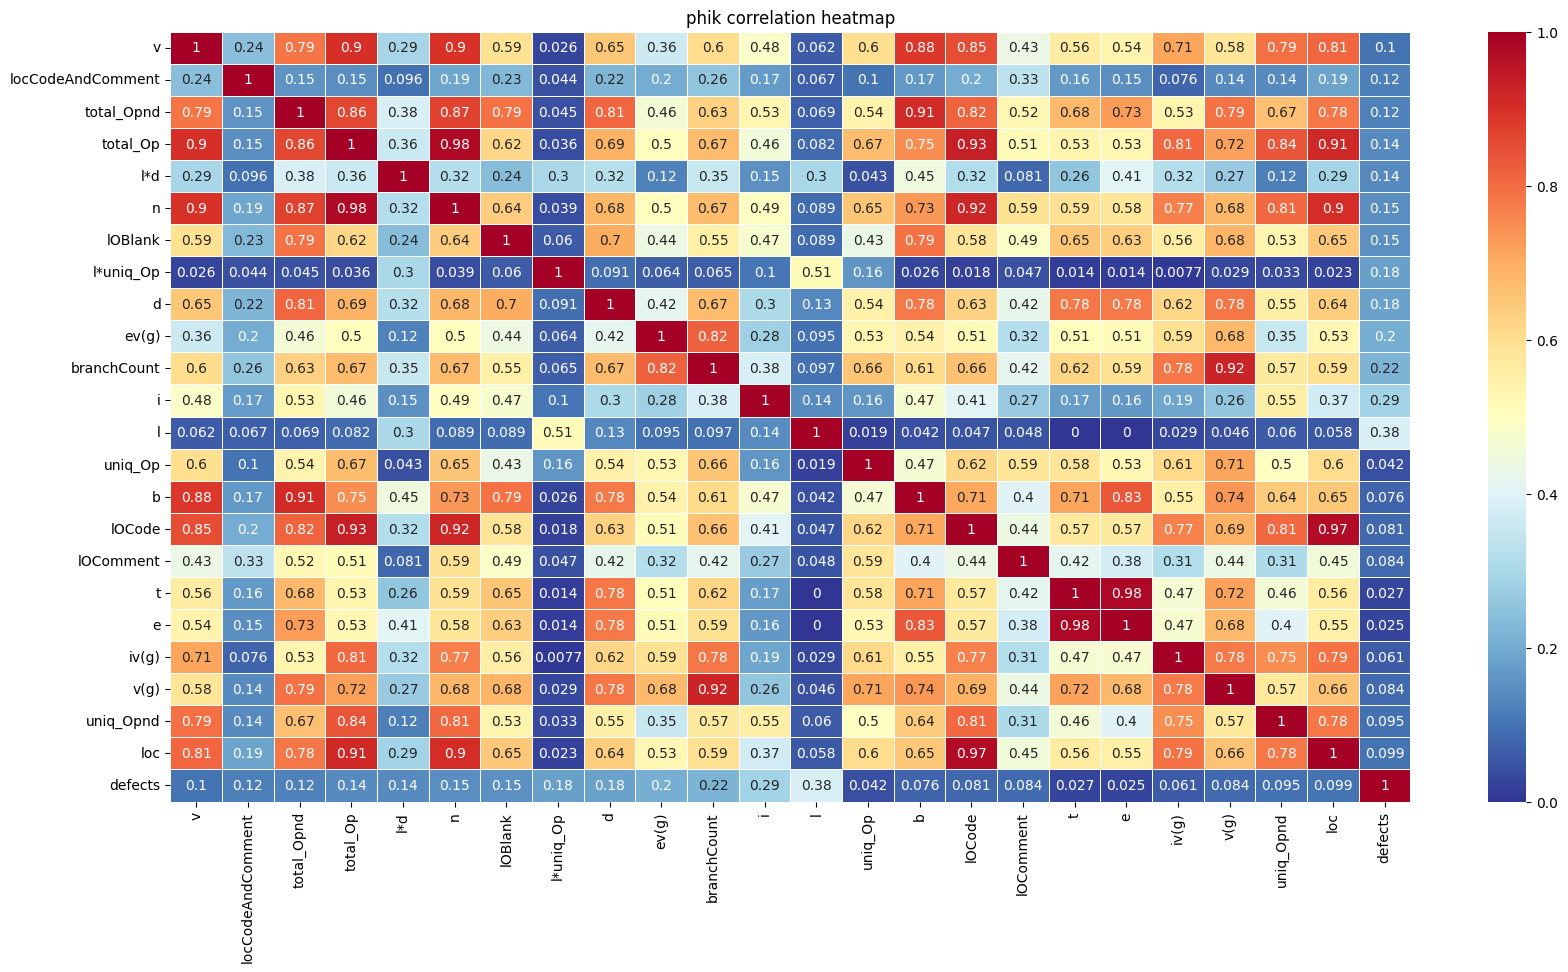

In [55]:
correlation_matrix =  pd.concat([X_features,y], axis=1).phik_matrix()

plt.figure(figsize=(20,10))
sns.heatmap(correlation_matrix,
        xticklabels=correlation_matrix.columns,
        yticklabels=correlation_matrix.columns,
        cmap='RdYlBu_r',
        annot=True,
        linewidth=0.5)

plt.title('phik correlation heatmap')
plt.show()

In [70]:
X_train, X_val, y_train, y_val = train_test_split(X_features, y, test_size=0.2, random_state=42, stratify=y)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [79]:
def create_model():
    model = Sequential()
    model.add(Dense(128, activation='relu',input_dim=X_train.shape[1]))
    model.add(BatchNormalization())
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['AUC']
                  )

    return model

In [80]:
model = create_model()

history = model.fit(X_train, y_train,
           validation_data=(X_val, y_val),
           epochs=50,
           batch_size=256,
           class_weight={0:class_weights[0], 1:class_weights[1]})

Epoch 1/50
319/319 [==============================] - 28s 7ms/step - loss: 0.5701 - auc: 0.7781 - val_loss: 0.5036 - val_auc: 0.7851
Epoch 2/50
319/319 [==============================] - 2s 7ms/step - loss: 0.5583 - auc: 0.7856 - val_loss: 0.5329 - val_auc: 0.7909
Epoch 3/50
319/319 [==============================] - 2s 7ms/step - loss: 0.5558 - auc: 0.7876 - val_loss: 0.5518 - val_auc: 0.7907
Epoch 4/50
319/319 [==============================] - 2s 6ms/step - loss: 0.5547 - auc: 0.7886 - val_loss: 0.5493 - val_auc: 0.7904
Epoch 5/50
319/319 [==============================] - 3s 8ms/step - loss: 0.5543 - auc: 0.7888 - val_loss: 0.5350 - val_auc: 0.7906
Epoch 6/50
319/319 [==============================] - 3s 10ms/step - loss: 0.5527 - auc: 0.7903 - val_loss: 0.5465 - val_auc: 0.7897
Epoch 7/50
319/319 [==============================] - 3s 8ms/step - loss: 0.5541 - auc: 0.7888 - val_loss: 0.5466 - val_auc: 0.7911
Epoch 8/50
319/319 [==============================] - 2s 6ms/step - loss: 

<ipython-input-16-1b78b09c4d6e>:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, train, 'b', label=f'Training {figure_name}', color='orange')


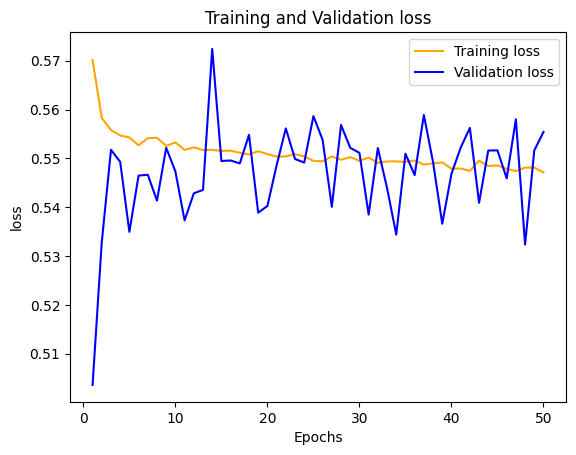

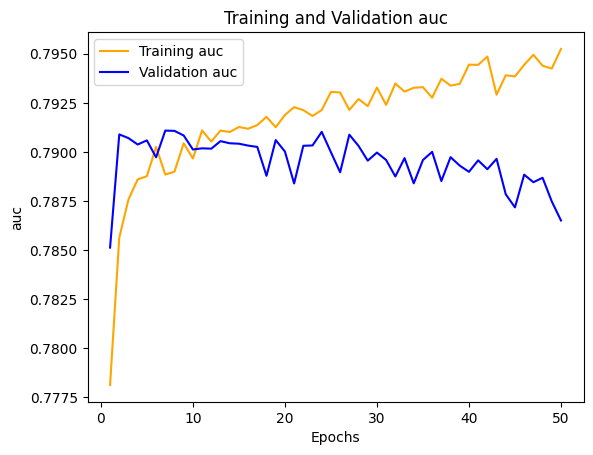

In [81]:
check_metrics(history, 'loss')
check_metrics(history, 'auc')

Батч нормализация замедляет переобучение, уменьшает шум функции потерь на валидационной выборке.

In [82]:
def create_model():
    model = Sequential()
    model.add(Dense(128, activation='relu',input_dim=X_train.shape[1]))
    model.add(Dropout(0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['AUC']
                  )

    return model

In [83]:
model = create_model()

history = model.fit(X_train, y_train,
           validation_data=(X_val, y_val),
           epochs=50,
           batch_size=256,
           class_weight={0:class_weights[0], 1:class_weights[1]})

Epoch 1/50
319/319 [==============================] - 4s 10ms/step - loss: 0.5686 - auc: 0.7776 - val_loss: 0.5641 - val_auc: 0.7892
Epoch 2/50
319/319 [==============================] - 3s 9ms/step - loss: 0.5590 - auc: 0.7859 - val_loss: 0.5602 - val_auc: 0.7907
Epoch 3/50
319/319 [==============================] - 2s 6ms/step - loss: 0.5581 - auc: 0.7862 - val_loss: 0.5550 - val_auc: 0.7915
Epoch 4/50
319/319 [==============================] - 2s 6ms/step - loss: 0.5560 - auc: 0.7879 - val_loss: 0.5347 - val_auc: 0.7912
Epoch 5/50
319/319 [==============================] - 2s 6ms/step - loss: 0.5555 - auc: 0.7879 - val_loss: 0.5468 - val_auc: 0.7910
Epoch 6/50
319/319 [==============================] - 2s 6ms/step - loss: 0.5547 - auc: 0.7889 - val_loss: 0.5420 - val_auc: 0.7908
Epoch 7/50
319/319 [==============================] - 2s 6ms/step - loss: 0.5542 - auc: 0.7891 - val_loss: 0.5596 - val_auc: 0.7921
Epoch 8/50
319/319 [==============================] - 3s 9ms/step - loss: 0

<ipython-input-16-1b78b09c4d6e>:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, train, 'b', label=f'Training {figure_name}', color='orange')


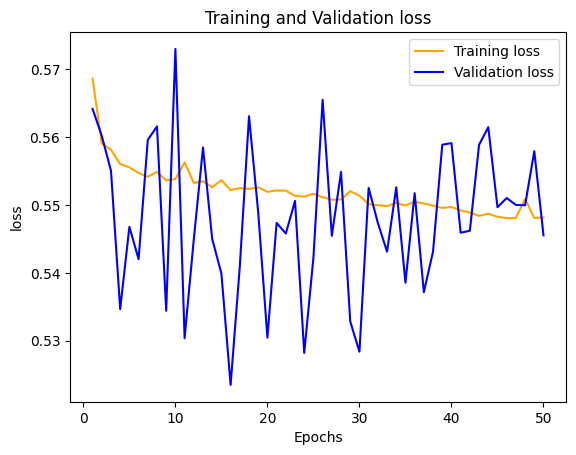

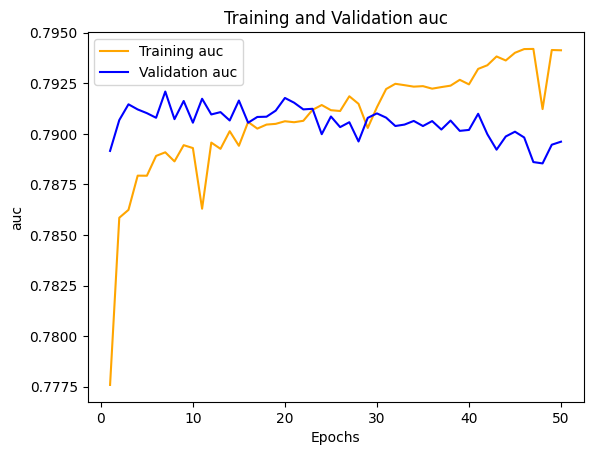

In [84]:
check_metrics(history, 'loss')
check_metrics(history, 'auc')

Дропаут сильнее чем батч нормализация замедляет переобучение, незначительно уменьшает шум лос функции на валидационной выборке


In [88]:
def create_model():
    model = Sequential()
    model.add(Dense(128, activation='relu',input_dim=X_train.shape[1]))
    model.add(Dropout(0.1))
    model.add(BatchNormalization())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.1))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['AUC']
                  )

    return model

In [89]:
model = create_model()

history = model.fit(X_train, y_train,
           validation_data=(X_val, y_val),
           epochs=50,
           batch_size=256,
           class_weight={0:class_weights[0], 1:class_weights[1]})

Epoch 1/50
319/319 [==============================] - 5s 9ms/step - loss: 0.5888 - auc: 0.7646 - val_loss: 0.5425 - val_auc: 0.7873
Epoch 2/50
319/319 [==============================] - 3s 8ms/step - loss: 0.5684 - auc: 0.7789 - val_loss: 0.5420 - val_auc: 0.7903
Epoch 3/50
319/319 [==============================] - 3s 10ms/step - loss: 0.5635 - auc: 0.7818 - val_loss: 0.5475 - val_auc: 0.7894
Epoch 4/50
319/319 [==============================] - 4s 11ms/step - loss: 0.5608 - auc: 0.7839 - val_loss: 0.5420 - val_auc: 0.7904
Epoch 5/50
319/319 [==============================] - 2s 8ms/step - loss: 0.5585 - auc: 0.7857 - val_loss: 0.5531 - val_auc: 0.7903
Epoch 6/50
319/319 [==============================] - 3s 8ms/step - loss: 0.5570 - auc: 0.7866 - val_loss: 0.5533 - val_auc: 0.7900
Epoch 7/50
319/319 [==============================] - 2s 8ms/step - loss: 0.5569 - auc: 0.7867 - val_loss: 0.5529 - val_auc: 0.7917
Epoch 8/50
319/319 [==============================] - 4s 11ms/step - loss:

<ipython-input-16-1b78b09c4d6e>:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, train, 'b', label=f'Training {figure_name}', color='orange')


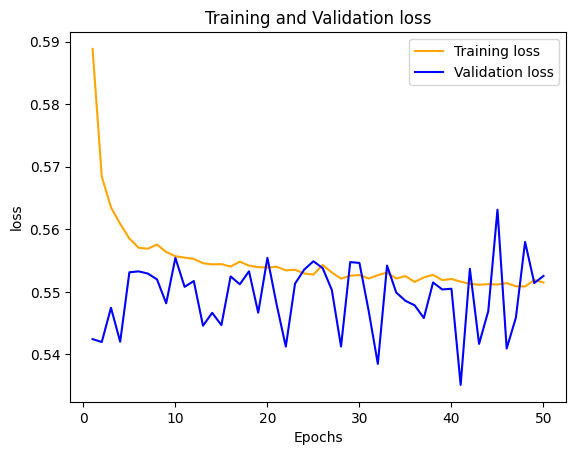

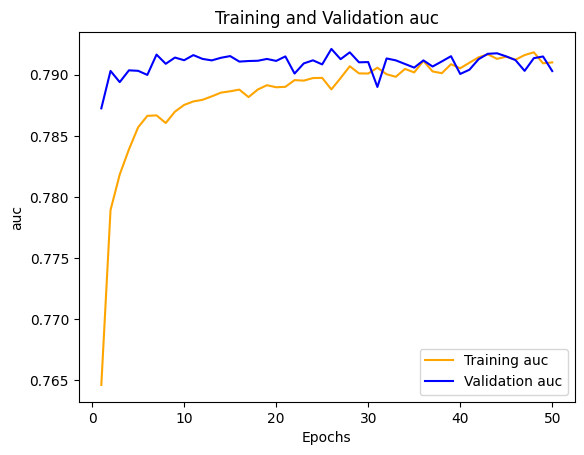

In [90]:
check_metrics(history, 'loss')
check_metrics(history, 'auc')

Если одновременно использовать дропаут и батч нормализацию, модель не переобучается (за заданное количество эпох). Также не смотря на то, что значения метрики ROC_AUC по валидационной выборке у исходной модели могли быть незначительно лучше, конечная модель будет лучше т.к. метрики на тренировочной и валидационной выборке близки, что может говорить о сильной обобщающей способности

In [91]:
model = create_model()

early_stopping = EarlyStopping(monitor='val_auc', patience=10)
save_best_weights = ModelCheckpoint(filepath='./',
                                    save_weights_only=True,
                                    monitor='val_auc',
                                    mode='max',
                                    save_best_only=True)

history = model.fit(X_train, y_train,
           validation_data=(X_val, y_val),
           epochs=50,
           batch_size=256,
           class_weight={0:class_weights[0],1:class_weights[1]},
           callbacks=[early_stopping,save_best_weights])

Epoch 1/50
319/319 [==============================] - 9s 12ms/step - loss: 0.5882 - auc: 0.7662 - val_loss: 0.5277 - val_auc: 0.7875
Epoch 2/50
319/319 [==============================] - 3s 8ms/step - loss: 0.5672 - auc: 0.7795 - val_loss: 0.5438 - val_auc: 0.7896
Epoch 3/50
319/319 [==============================] - 3s 8ms/step - loss: 0.5627 - auc: 0.7826 - val_loss: 0.5347 - val_auc: 0.7900
Epoch 4/50
319/319 [==============================] - 3s 9ms/step - loss: 0.5595 - auc: 0.7853 - val_loss: 0.5594 - val_auc: 0.7911
Epoch 5/50
319/319 [==============================] - 4s 13ms/step - loss: 0.5583 - auc: 0.7858 - val_loss: 0.5459 - val_auc: 0.7912
Epoch 6/50
319/319 [==============================] - 3s 8ms/step - loss: 0.5582 - auc: 0.7856 - val_loss: 0.5428 - val_auc: 0.7914
Epoch 7/50
319/319 [==============================] - 3s 8ms/step - loss: 0.5570 - auc: 0.7865 - val_loss: 0.5491 - val_auc: 0.7916
Epoch 8/50
319/319 [==============================] - 2s 7ms/step - loss: 

<ipython-input-16-1b78b09c4d6e>:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, train, 'b', label=f'Training {figure_name}', color='orange')


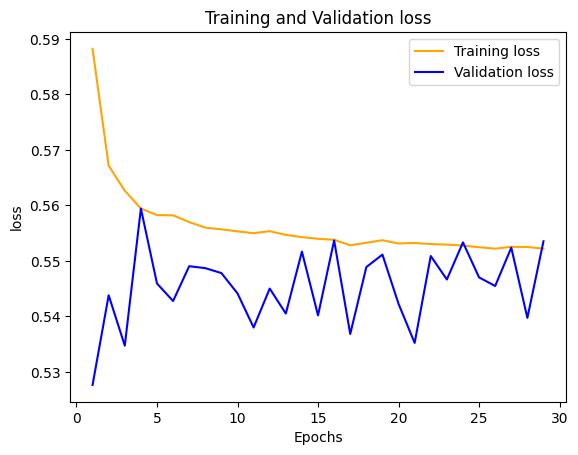

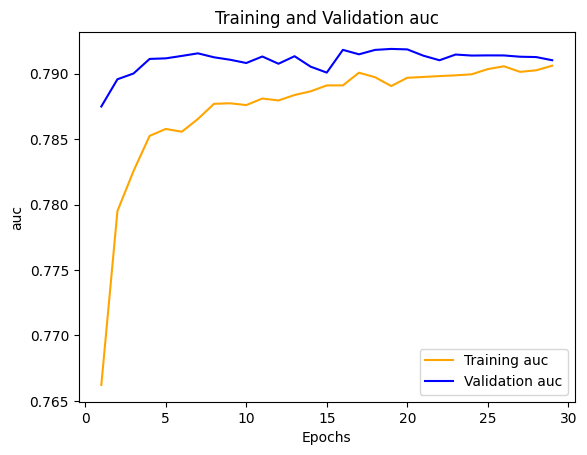

In [92]:
check_metrics(history, 'loss')
check_metrics(history, 'auc')

**Вывод:** Не получилось добавить или удалить фичи которые значительно улучшили качество модели. Попробовал преобразовать фичи простыми математическими функциями. Phik кореляция посчитала преобразования недостаточными. Также попробовал полиномиальные фичи и RBFSampler, и другие приколы, но получить значительный отрыв не получилось.


Дропаут сильнее чем батч нормализация замедляет переобучение, незначительно уменьшает шум лос функции на валидационной выборке

Батч нормализация замедляет переобучение, уменьшает шум функции потерь на валидационной выборке.

Если одновременно использовать дропаут и батч нормализацию, модель не переобучается (за заданное количество эпох). Также не смотря на то, что значения метрики ROC_AUC по валидационной выборке у исходной модели могли быть незначительно лучше, конечная модель будет лучше т.к. метрики на тренировочной и валидационной выборке близки, что может говорить о сильной обобщающей способности

Можно сказать что добавленные полиномиальные фичи улучшили качество модели, удаление id точно не ухудшило предсказательную способность, удаление всех фичей кроме наиболее коррелирующих также дает не наилучший результат. (поэтому исходные фичи были оставлены)

модель с дропаутом и финальная модель обученная на 50 эпох дали лучшее значение ROC_AUC равное 0.7921